# 第7章　EMアルゴリズム：最尤推定法による教師なし学習

## 7.2 混合分布を用いた最尤推定法

**[07EM-01]**

必要なモジュールをインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from numpy.random import rand

**[07EM-02]**

MNISTの画像イメージをダウンロードします。

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11493376/11490434 [==============================] - 0s 0us/step


**[07EM-03]**

0, 3, 6 のイメージのみを600枚抽出して、モノクロ２階調に変換します。

In [3]:
def to_mono(x):
  if x > 0.5:
    return 1.0
  return 0

def prep_data(num=600, digits=[0, 3, 6]):
  mono_images = []
  for (image, label) in zip(train_images, train_labels):
    if np.argmax(label) not in digits:
      continue
    mono_images.append(np.array(list(map(to_mono, image))))
    if len(mono_images) == num:
      break
  return mono_images

sample_images = prep_data(600, [0, 3, 6])

**[07EM-04]**

抽出したイメージのサンプルを表示します。

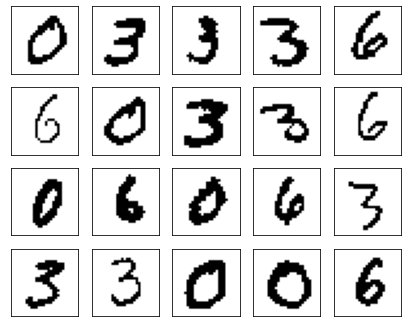

In [4]:
fig = plt.figure(figsize=(7, 5.7))
for c, image in enumerate(sample_images[:20]):
  subplot = fig.add_subplot(4, 5, c+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)

**[07EM-05]**

EMアルゴリズムを実行する関数を定義します。

関数 `bernoulli` は、画像生成器 $\boldsymbol\mu_k$ から画像 $\mathbf x$ が得られる確率を次式で計算します。
$$
p_{\mu_k}(\mathbf x) = \prod_{i=1}^D[\boldsymbol\mu_k]_i^{x_i}(1-[\boldsymbol\mu_k]_i)^{1-x_i}
$$

関数 `run_em` は、EM法の繰り返し処理を1回だけ実施します。変数 `gamma`、`mu`、`pi` は、それぞれ、$\gamma_{nk}$、$\boldsymbol\mu_k$、$\pi_k$ の値を保存します。

"E phase" では、$\gamma_{nk}$ の値を次式で計算します。
$$
\gamma_{nk} = \frac{\pi_kp_{\mu_k}(\mathbf x_n)}{\displaystyle\sum_{k'=1}^K\pi_{k'}p_{\mu_{k'}}(\mathbf x_n)}
$$

"M phase" では、$\boldsymbol\mu_k$ と $\pi_k$ の値を次式で再設定します。
$$
\boldsymbol\mu_k = \frac{\displaystyle\sum_{n=1}^N\gamma_{nk}\mathbf x_n}{\displaystyle\sum_{n=1}^N\gamma_{nk}},\ 
\pi_k = \frac{\displaystyle\sum_{n=1}^N\gamma_{nk}}{N}
$$

これらの計算を行った後、変数 `group` には、それぞれの画像が属するクラスター（その画像が生成される確率が最も高い画像生成器）の番号が保存されます。


In [5]:
def bernoulli(x, mu):
  r = 1.0
  for x_i, mu_i in zip(x, mu):
    r *= mu_i**x_i * (1-mu_i)**(1-x_i)
  return r

def run_em(images, num_clusters, pi, mu):
  # E phase：gamma を計算
  gamma = []
  for image in images:
    gamma_n = np.array(
        [pi[k] * bernoulli(image, mu[k]) for k in range(num_clusters)])
    if np.sum(gamma_n) != 0: # avoid zero-division in case of underflow
      gamma_n = gamma_n / np.sum(gamma_n) # normalization
    gamma.append(gamma_n)

  gamma = np.array(gamma)

  # M phase：mu, pi を更新
  new_pi = np.array([np.sum(gamma[:, k]) for k in range(num_clusters)])
  new_pi = new_pi / np.sum(new_pi) # normalization

  new_mu = []
  for k in range(num_clusters):
    mu_k = np.sum([gamma[n, k] * x_n for n, x_n in enumerate(images)],
                  axis=0) # sum up over n
    new_mu.append(mu_k / (new_pi[k] * len(images)))
  
  new_mu = np.array(new_mu)

  group = list(map(np.argmax, gamma))
        
  return new_pi, new_mu, group

**[07EM-06]**

画像生成器を画像イメージとして表示する関数を定義します。

In [6]:
def show_images(mu):
  fig = plt.figure(figsize=(5, 2))
  num_clusters = len(mu)
  for k in range(num_clusters):
    subplot = fig.add_subplot(1, num_clusters, k+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(mu[k].reshape(28, 28), cmap=plt.cm.gray_r)

**[07EM-07]**

初期の画像生成器を乱数で用意して、表示します。

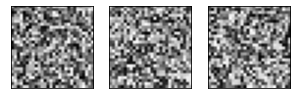

In [7]:
K = 3
pi = np.ones(K) / K
mu = (rand(28*28*K)*0.5+0.25).reshape(K, 28*28)
for k in range(K):
  mu[k] /= np.sum(mu[k])

show_images(mu)

**[07EM-08]**

EM法の繰り返し処理を1回だけ適用した結果を表示します。

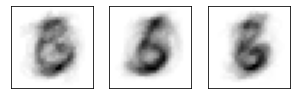

In [8]:
pi, mu, group = run_em(sample_images, K, pi, mu)
show_images(mu)

**[07EM-09]**

初期の画像生成器を乱数で用意した後に、指定した回数だけEM法の繰り返し処理を実行する関数を定義します。

In [9]:
def experiment(images, num_clusters, num_iteration):
  pi = np.ones(num_clusters) / num_clusters
  mu = (rand(28*28*num_clusters)*0.5+0.25).reshape(num_clusters, 28*28)
  for k in range(num_clusters):
    mu[k] /= np.sum(mu[k])

  result = []
  result.append(mu)

  for i in range(num_iteration):
    print('Iteration {}/{}.'.format(i+1, num_iteration))
    pi, mu, group = run_em(sample_images, num_clusters, pi, mu)
    result.append(mu)

  return result, pi, mu, group

**[07EM-10]**

クラスター数に 3 を指定して、EM法の処理を10回繰り返します。

変数 `result` には、繰り返しごとの画像生成器の変化が保存されます。

In [10]:
result, pi, mu, group = experiment(sample_images, 3, 10)

Iteration 1/10.
Iteration 2/10.
Iteration 3/10.
Iteration 4/10.
Iteration 5/10.
Iteration 6/10.
Iteration 7/10.
Iteration 8/10.
Iteration 9/10.
Iteration 10/10.


**[07EM-11]**

画像生成器が変化する様子を表示します。

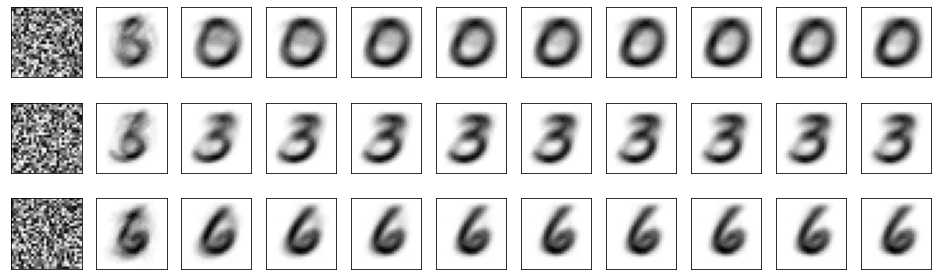

In [11]:
def show_iterations(result):
  fig = plt.figure(figsize=(len(result)*1.5, len(result[0])*5/3))
  for i, mu in enumerate(result):
    for k in range(len(mu)):
      subplot = fig.add_subplot(len(mu), len(result), 1+k*len(result)+i)
      subplot.set_xticks([])
      subplot.set_yticks([]) 
      subplot.imshow(mu[k].reshape(28, 28), cmap=plt.cm.gray_r)

show_iterations(result)

**[07EM-12]**

最終的な画像生成器（代表文字）とそれぞれのクラスターに属する画像のサンプルを表示します。

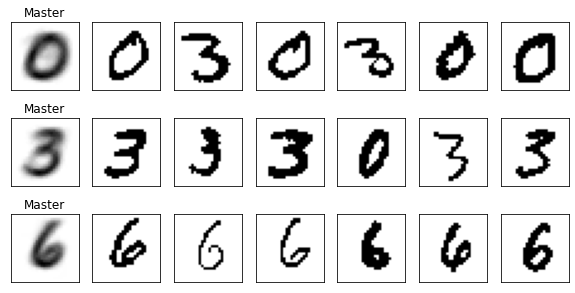

In [12]:
def show_figure(images, mu, group):
  num_clusters = len(mu)
  num = 6

  fig = plt.figure(figsize=((num+1)*10/7, num_clusters*5/3))
  for k in range(num_clusters):
    subplot = fig.add_subplot(num_clusters, num+1, 1+k*(num+1))
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Master', fontsize=12)
    subplot.imshow(mu[k].reshape(28, 28), cmap=plt.cm.gray_r)

    i = 1
    for j in range(len(group)):
      if group[j] == k:
        subplot = fig.add_subplot(num_clusters, num+1, 1+k*(num+1)+i)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(images[j].reshape(28,28), cmap=plt.cm.gray_r)
        i += 1
        if i > num:
          break

show_figure(sample_images, mu, group)

**[07EM-13]**

クラスター数を 4 にして、同様の処理を行います。

In [16]:
result, pi, mu, group = experiment(sample_images, 4, 10)

Iteration 1/10.
Iteration 2/10.
Iteration 3/10.
Iteration 4/10.
Iteration 5/10.
Iteration 6/10.
Iteration 7/10.
Iteration 8/10.
Iteration 9/10.
Iteration 10/10.


**[07EM-14]**

画像生成器が変化する様子を表示します。

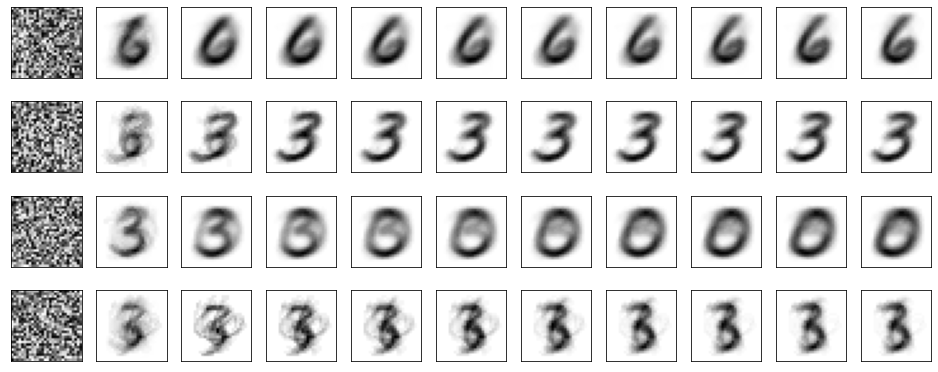

In [17]:
show_iterations(result)

**[07EM-15]**

最終的な画像生成器（代表文字）とそれぞれのクラスターに属する画像のサンプルを表示します。

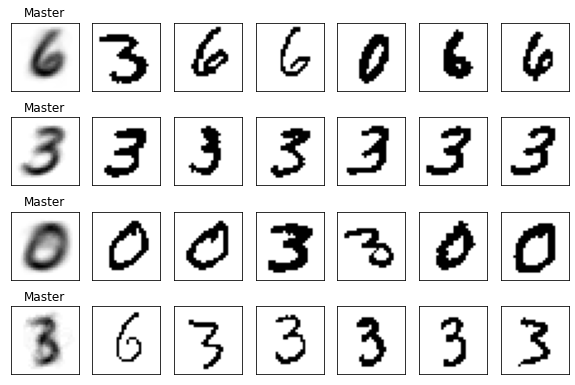

In [18]:
show_figure(sample_images, mu, group)